In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
from PIL import Image
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
#resnet 50 için 
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings("ignore")

In [3]:
#csv dosyalarını okuyalım
train_df= pd.read_csv("Train.csv", usecols=["ClassId", "Path"])
test_df=pd.read_csv("Test.csv", usecols=["ClassId", "Path"])

In [4]:
train_df.head()

,ClassId,Path
0,20,Train/20/00020_00000_00000.png
1,20,Train/20/00020_00000_00001.png
2,20,Train/20/00020_00000_00002.png
3,20,Train/20/00020_00000_00003.png
4,20,Train/20/00020_00000_00004.png


In [5]:
test_df.head()

,ClassId,Path
0,16,Test/00000.png
1,1,Test/00001.png
2,38,Test/00002.png
3,33,Test/00003.png
4,11,Test/00004.png


In [6]:
images= []
labels= []

def load_data(df):
    images= []
    labels= []
    for _ , row in df.iterrows():
        img_path= os.path.join("C:/Users/PANDA/traffic/", row["Path"])
        img= cv2.imread(img_path)
        img= cv2.resize(img, (64,64))
        img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img= img / 255.0
        images.append(img)
        labels.append(row["ClassId"])
    return np.array(images), np.array(labels)

In [7]:
# verileri load edelim
X_train, y_train= load_data(train_df)
X_test, y_test= load_data(test_df)

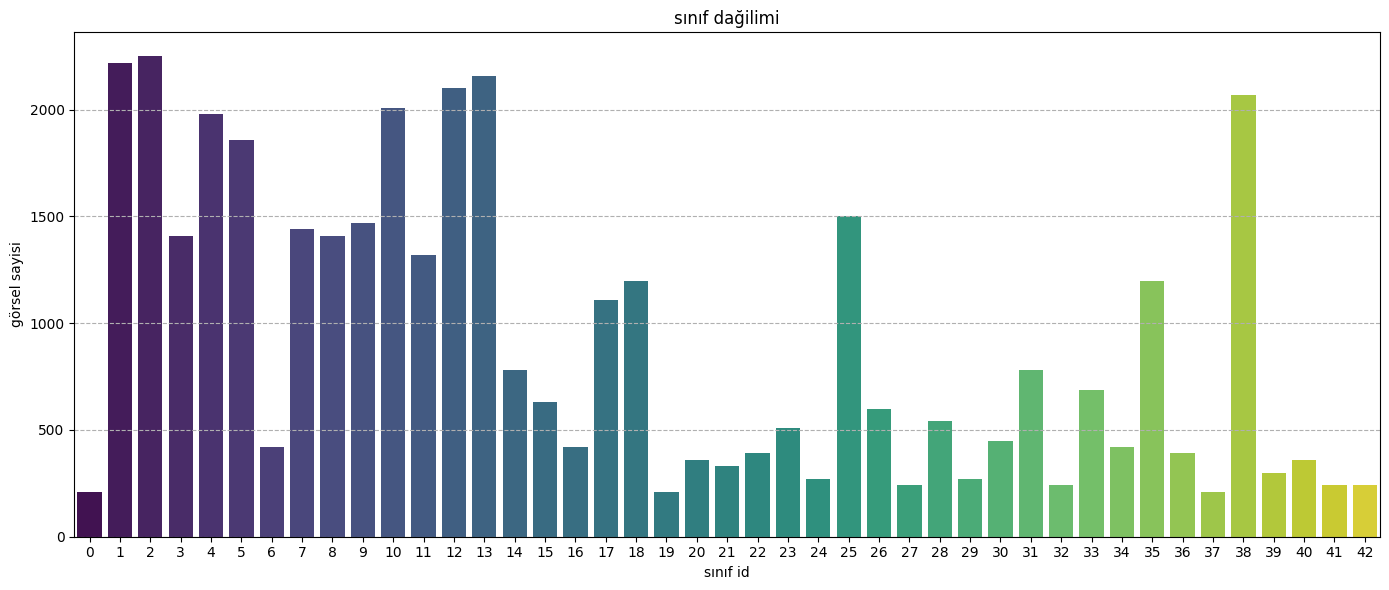

In [8]:
# sınıf dağılımlarını kontrol edelim
plt.figure(figsize=(14,6))
sns.countplot(x="ClassId", data= train_df, palette="viridis")
plt.title("sınıf dağilimi")
plt.xlabel("sınıf id")
plt.ylabel("görsel sayisi")
plt.grid(axis='y', linestyle= "--")
plt.tight_layout()
plt.show()

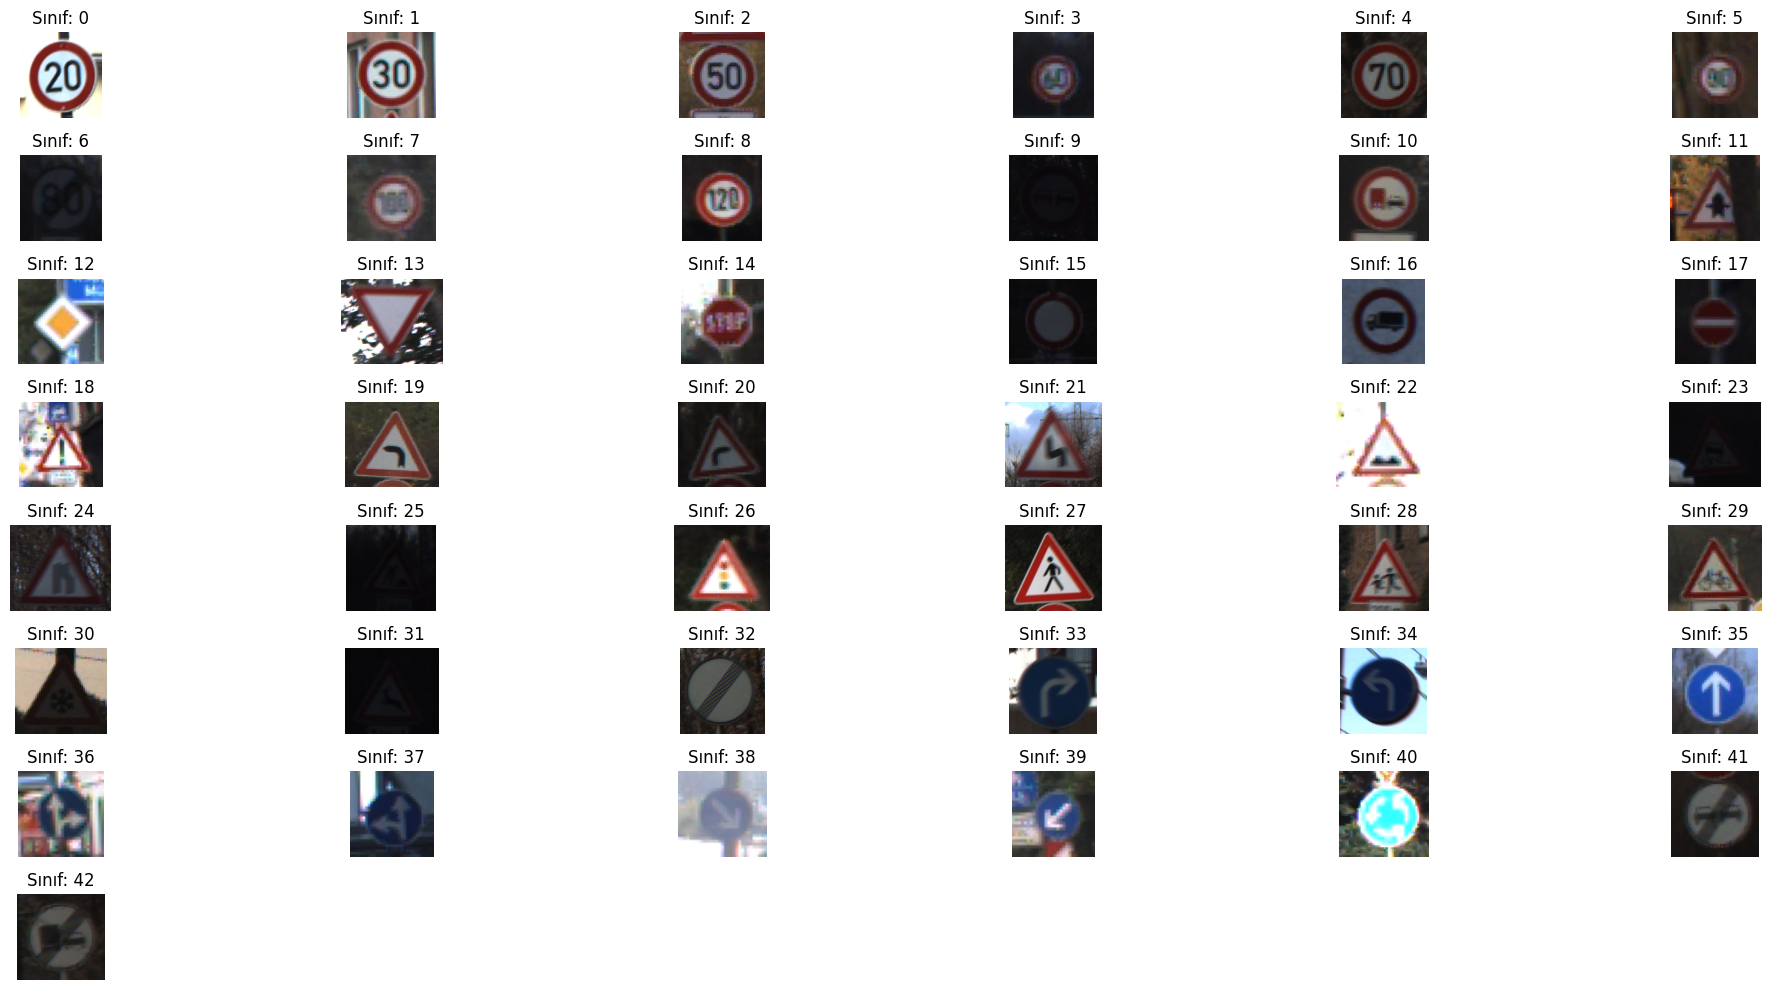

In [9]:
#train veri setinden örnek görselleştirelim
#cv2 ile görselleri okuyup PIL ile görselleştirdiğimiz 
# (yukarıya bgr -> rgb ekle) +
plt.figure(figsize=(20, 10))
classes = sorted(train_df['ClassId'].unique())

for i, c in enumerate(classes):
    sample = train_df[train_df['ClassId'] == c].sample(1).iloc[0]
    img = Image.open(sample['Path'])

    plt.subplot(8, 6, i+1)
    plt.imshow(img)
    plt.title(f"Sınıf: {c}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## data preprocessing

In [10]:
train_datagen= ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  zoom_range=0.15,
                                  shear_range=0.05,
                                  horizontal_flip=False,
                                  fill_mode="nearest")
val_datagen=ImageDataGenerator()

In [11]:
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [12]:
train_df["ClassId"].nunique()

43

In [13]:
y_train= to_categorical(y_train, num_classes=43)
y_val= to_categorical(y_val, num_classes=43)

In [14]:
batch_size=32

In [15]:
print(y_val.shape)
print(y_train.shape)
print(X_train.shape)
print(X_val.shape)

(7842, 43)
(31367, 43)
(31367, 64, 64, 3)
(7842, 64, 64, 3)


In [16]:
train_generator= train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)
val_generator= val_datagen.flow(X_val, y_val, batch_size=batch_size, shuffle=False)

In [17]:
x, y = next(train_generator)
print(x.min(), x.max())      
print(y.shape)              
print(y[0].sum())

0.019472715 1.0
(32, 43)
1.0


## build cnn model

In [18]:
def build_traffic_sign_classifier(input_shape=(64,64,3) ,num_classes=43): 
    model = Sequential()
    #1.conv
    model.add(Conv2D(32, (3,3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    
    #2.conv
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))
    
    
    #3.conv
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))
    
    #fc
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.45))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [19]:
first_model = build_traffic_sign_classifier(input_shape=(64,64,3), num_classes=43)
first_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [20]:
callbacks = [ModelCheckpoint("gtsrb_best.weights.h5", monitor='val_accuracy', save_best_only=True, verbose=1),
             EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
             ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)]

In [21]:
first_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,395,595 (9.14 MB)

 Trainable params: 2,395,531 (9.14 MB)

 Non-trainable params: 64 (256.00 B)

### fit the model

In [22]:
history = first_model.fit(train_generator, validation_data=val_generator, epochs=30, callbacks=callbacks)


Epoch 1/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.2602 - loss: 2.6683  
Epoch 1: val_accuracy improved from -inf to 0.84545, saving model to gtsrb_best.weights.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 232s 232ms/step - accuracy: 0.2604 - loss: 2.6675 - val_accuracy: 0.8454 - val_loss: 0.5208 - learning_rate: 0.0010
Epoch 2/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.7576 - loss: 0.7840  
Epoch 2: val_accuracy improved from 0.84545 to 0.97156, saving model to gtsrb_best.weights.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 214s 218ms/step - accuracy: 0.7576 - loss: 0.7838 - val_accuracy: 0.9716 - val_loss: 0.0926 - learning_rate: 0.0010
Epoch 3/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.8924 - loss: 0.3641  
Epoch 3: val_accuracy improved from 0.97156 to 0.98827, saving model to gtsrb_best.weights.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 218s 223ms/step - accuracy: 0.8924 - loss: 0.3641 - val_accuracy: 0.9883 - val_loss: 0.0407 - learning_rate: 0.0010
Epoch 4/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9304 - loss: 0.2292  
Epoch 4: val_accuracy improved from 0.98827 to 0.99554, saving model to gtsrb_best.weights.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 216s 220ms/step - accuracy: 0.9304 - loss: 0.2292 - val_accuracy: 0.9955 - val_loss: 0.0163 - learning_rate: 0.0010
Epoch 5/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9478 - loss: 0.1925  
Epoch 5: val_accuracy did not improve from 0.99554
981/981 ━━━━━━━━━━━━━━━━━━━━ 233s 237ms/step - accuracy: 0.9478 - loss: 0.1925 - val_accuracy: 0.9923 - val_loss: 0.0263 - learning_rate: 0.0010
Epoch 6/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9518 - loss: 0.1762  
Epoch 6: val_accuracy did not improve from 0.99554
981/981 ━━━━━━━━━━━━━━━━━━━━ 222s 227ms/step - accuracy: 0.9518 - loss: 0.1762 - val_accuracy: 0.9941 - val_loss: 0.0195 - learning_rate: 0.0010
Epoch 7/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.9608 - loss: 0.1456  
Epoch 7: val_accuracy did not improve from 0.99554

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
981/981 ━━━━━━━━━━━━━━━━━━━━ 213s 217ms/step - accuracy: 0.9608 -

981/981 ━━━━━━━━━━━━━━━━━━━━ 205s 209ms/step - accuracy: 0.9732 - loss: 0.0901 - val_accuracy: 0.9983 - val_loss: 0.0063 - learning_rate: 5.0000e-04
Epoch 9/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9803 - loss: 0.0690  
Epoch 9: val_accuracy did not improve from 0.99834
981/981 ━━━━━━━━━━━━━━━━━━━━ 248s 253ms/step - accuracy: 0.9803 - loss: 0.0690 - val_accuracy: 0.9978 - val_loss: 0.0105 - learning_rate: 5.0000e-04
Epoch 10/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9826 - loss: 0.0646  
Epoch 10: val_accuracy did not improve from 0.99834
981/981 ━━━━━━━━━━━━━━━━━━━━ 273s 279ms/step - accuracy: 0.9826 - loss: 0.0646 - val_accuracy: 0.9981 - val_loss: 0.0056 - learning_rate: 5.0000e-04
Epoch 11/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9826 - loss: 0.0617  
Epoch 11: val_accuracy improved from 0.99834 to 0.99872, saving model to gtsrb_best.weights.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 238s 243ms/step - accuracy: 0.9826 - loss: 0.0617 - val_accuracy: 0.9987 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 12/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9824 - loss: 0.0627  
Epoch 12: val_accuracy improved from 0.99872 to 0.99898, saving model to gtsrb_best.weights.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 220s 224ms/step - accuracy: 0.9824 - loss: 0.0627 - val_accuracy: 0.9990 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 13/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.9834 - loss: 0.0557  
Epoch 13: val_accuracy did not improve from 0.99898
981/981 ━━━━━━━━━━━━━━━━━━━━ 207s 211ms/step - accuracy: 0.9834 - loss: 0.0557 - val_accuracy: 0.9986 - val_loss: 0.0072 - learning_rate: 5.0000e-04
Epoch 14/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9843 - loss: 0.0579  
Epoch 14: val_accuracy improved from 0.99898 to 0.99911, saving model to gtsrb_best.weights.h5



Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
981/981 ━━━━━━━━━━━━━━━━━━━━ 231s 236ms/step - accuracy: 0.9843 - loss: 0.0579 - val_accuracy: 0.9991 - val_loss: 0.0047 - learning_rate: 5.0000e-04
Epoch 15/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.9890 - loss: 0.0337  
Epoch 15: val_accuracy improved from 0.99911 to 0.99949, saving model to gtsrb_best.weights.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 227s 232ms/step - accuracy: 0.9890 - loss: 0.0337 - val_accuracy: 0.9995 - val_loss: 0.0026 - learning_rate: 2.5000e-04
Epoch 16/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.9910 - loss: 0.0293  
Epoch 16: val_accuracy improved from 0.99949 to 0.99962, saving model to gtsrb_best.weights.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 215s 219ms/step - accuracy: 0.9910 - loss: 0.0293 - val_accuracy: 0.9996 - val_loss: 0.0019 - learning_rate: 2.5000e-04
Epoch 17/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.9923 - loss: 0.0277  
Epoch 17: val_accuracy did not improve from 0.99962
981/981 ━━━━━━━━━━━━━━━━━━━━ 213s 217ms/step - accuracy: 0.9923 - loss: 0.0277 - val_accuracy: 0.9992 - val_loss: 0.0021 - learning_rate: 2.5000e-04
Epoch 18/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.9902 - loss: 0.0318  
Epoch 18: val_accuracy did not improve from 0.99962
981/981 ━━━━━━━━━━━━━━━━━━━━ 216s 221ms/step - accuracy: 0.9902 - loss: 0.0318 - val_accuracy: 0.9991 - val_loss: 0.0026 - learning_rate: 2.5000e-04
Epoch 19/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.9919 - loss: 0.0272  
Epoch 19: val_accuracy did not improve from 0.99962

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
981/981 ━━━━━━━━━━━━━━━━━━━━ 228s 232ms/step -

981/981 ━━━━━━━━━━━━━━━━━━━━ 212s 216ms/step - accuracy: 0.9950 - loss: 0.0192 - val_accuracy: 0.9997 - val_loss: 0.0011 - learning_rate: 1.2500e-04
Epoch 22/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.9954 - loss: 0.0184  
Epoch 22: val_accuracy did not improve from 0.99974
981/981 ━━━━━━━━━━━━━━━━━━━━ 205s 209ms/step - accuracy: 0.9954 - loss: 0.0184 - val_accuracy: 0.9997 - val_loss: 0.0013 - learning_rate: 1.2500e-04
Epoch 23/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.9953 - loss: 0.0170  
Epoch 23: val_accuracy did not improve from 0.99974
981/981 ━━━━━━━━━━━━━━━━━━━━ 207s 211ms/step - accuracy: 0.9953 - loss: 0.0170 - val_accuracy: 0.9996 - val_loss: 0.0016 - learning_rate: 1.2500e-04
Epoch 24/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9963 - loss: 0.0147  
Epoch 24: val_accuracy did not improve from 0.99974
981/981 ━━━━━━━━━━━━━━━━━━━━ 205s 209ms/step - accuracy: 0.9963 - loss: 0.0147 - val_accuracy: 0.9997 - val_loss: 7.6676e-04

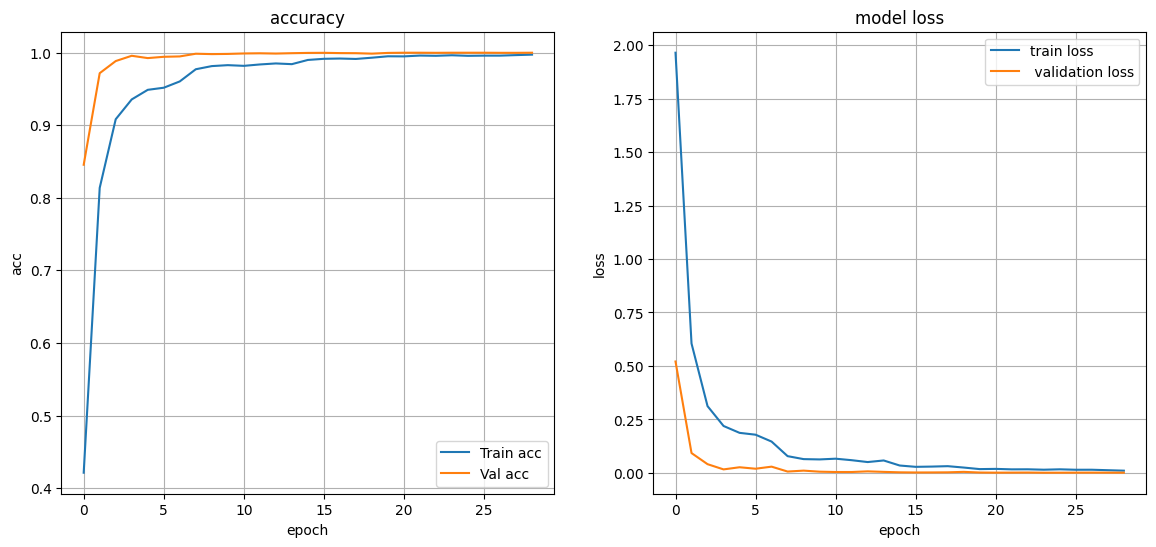

In [23]:
plt.figure(figsize=(14,6))

#acc graph
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train acc")
plt.plot(history.history["val_accuracy"], label="Val acc")
plt.title("accuracy")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.grid()

#loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label=" validation loss")
plt.title("model loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

## test seti ve performans ölçümü

In [25]:
# categorical_cross_entropy kullandığımız için val ve traine one hot encode yapmıştık o yüzden test için de aynısı
y_test= to_categorical(y_test, num_classes=43)

In [26]:
# model evalute
test_loss, test_acc = first_model.evaluate(X_test, y_test) 
print(f" test accuracy : {test_acc}")

395/395 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9862 - loss: 0.1433
 test accuracy : 0.9860649108886719


In [27]:
#tahminleri al
y_pred= first_model.predict(X_test)
y_pred_classes= np.argmax(y_pred, axis=1)
y_true_classes= np.argmax(y_test, axis=1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step


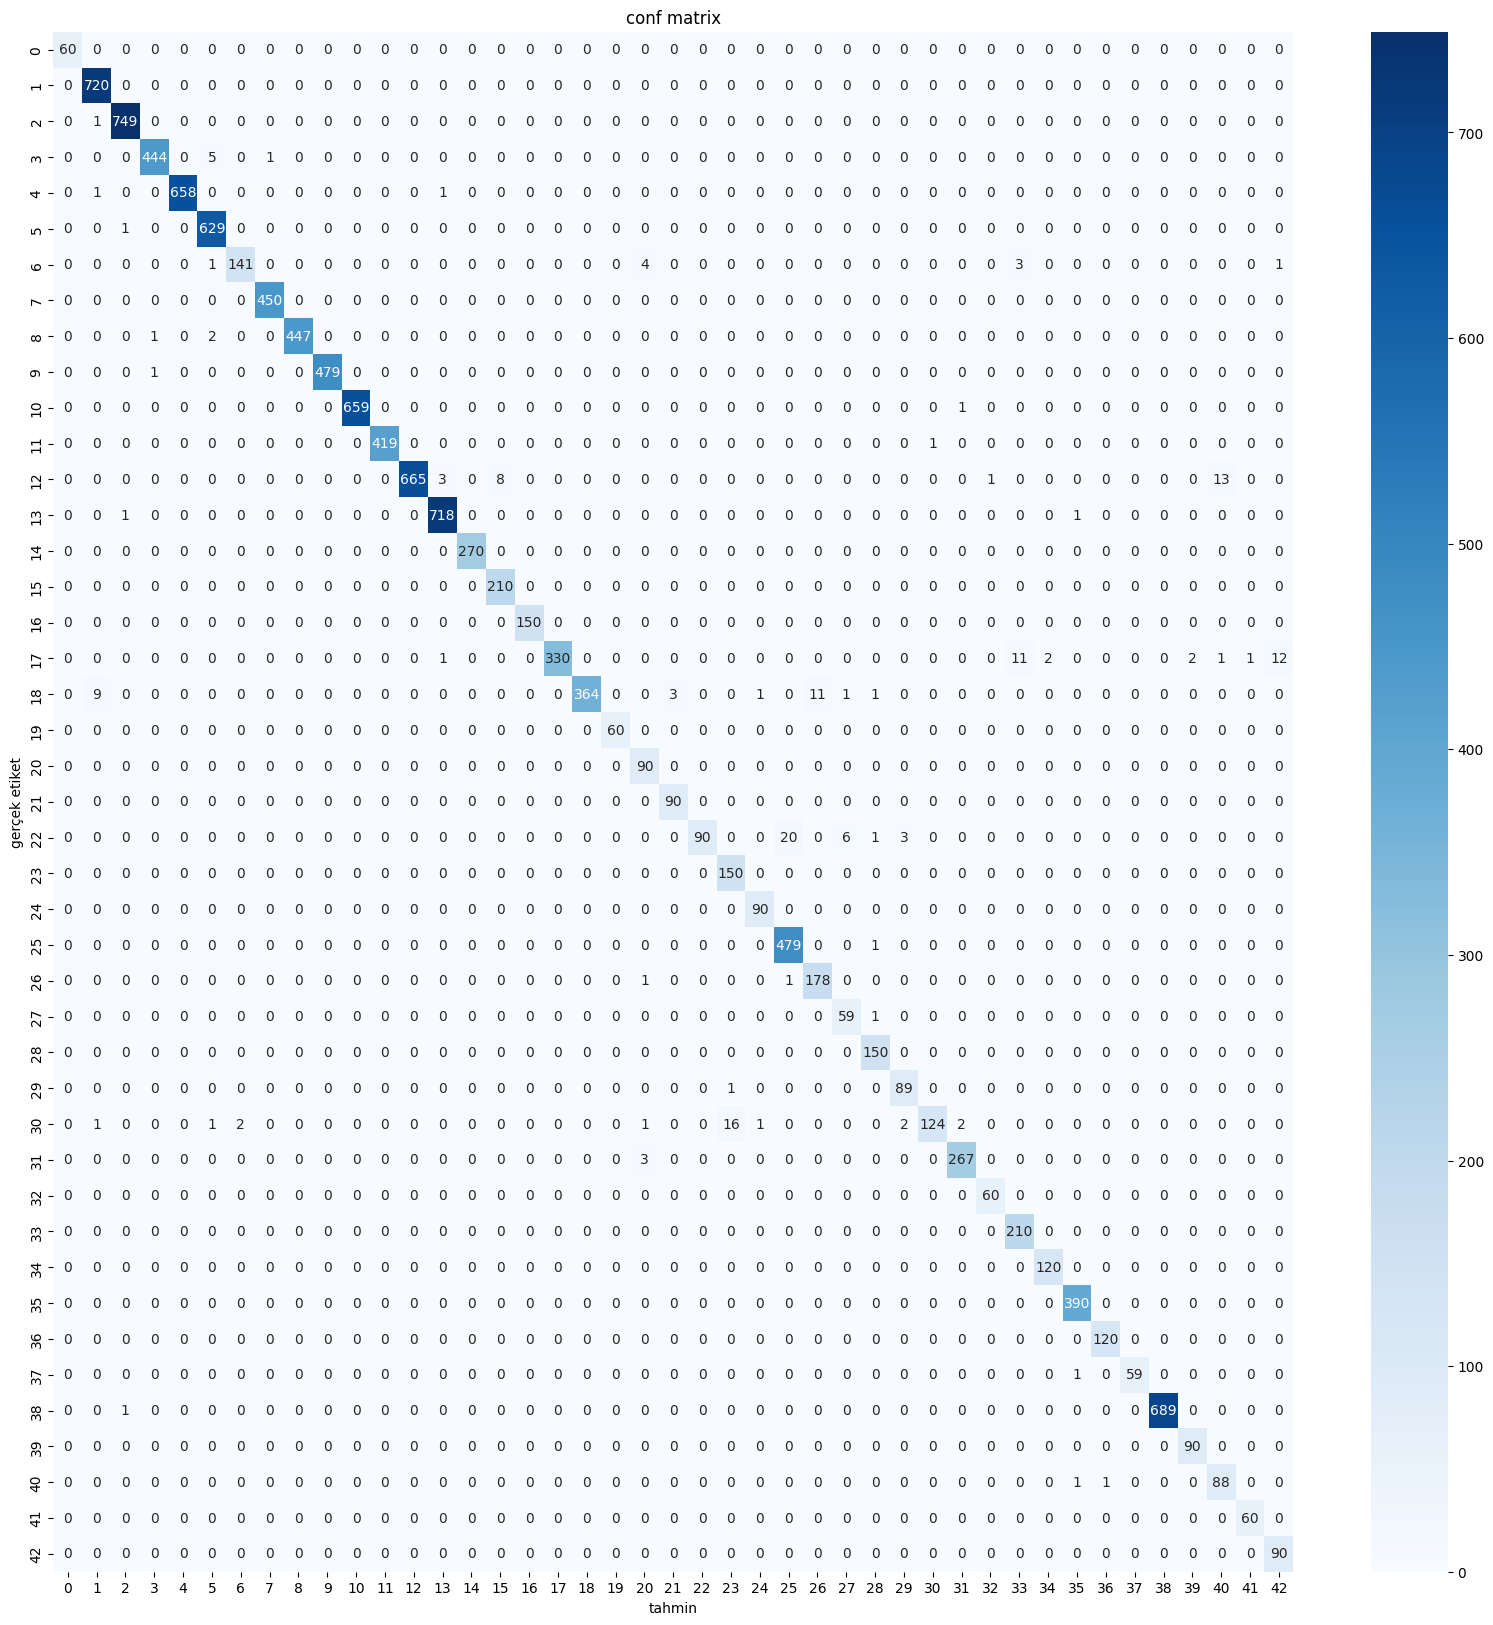

In [28]:
#conf matrix
plt.figure(figsize=(20,20))
sns.heatmap(confusion_matrix(y_true_classes, y_pred_classes), annot=True, fmt= "d", cmap="Blues")
plt.title("conf matrix")
plt.xlabel("tahmin")
plt.ylabel("gerçek etiket")
plt.show()

In [29]:
print(classification_report(y_true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.98      1.00      0.99       720
           2       1.00      1.00      1.00       750
           3       1.00      0.99      0.99       450
           4       1.00      1.00      1.00       660
           5       0.99      1.00      0.99       630
           6       0.99      0.94      0.96       150
           7       1.00      1.00      1.00       450
           8       1.00      0.99      1.00       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       1.00      1.00      1.00       420
          12       1.00      0.96      0.98       690
          13       0.99      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.96      1.00      0.98       210
          16       1.00      1.00      1.00       150
          17       1.00    

In [30]:
n=20
random_indices= random.sample(range(len(X_test)), n)

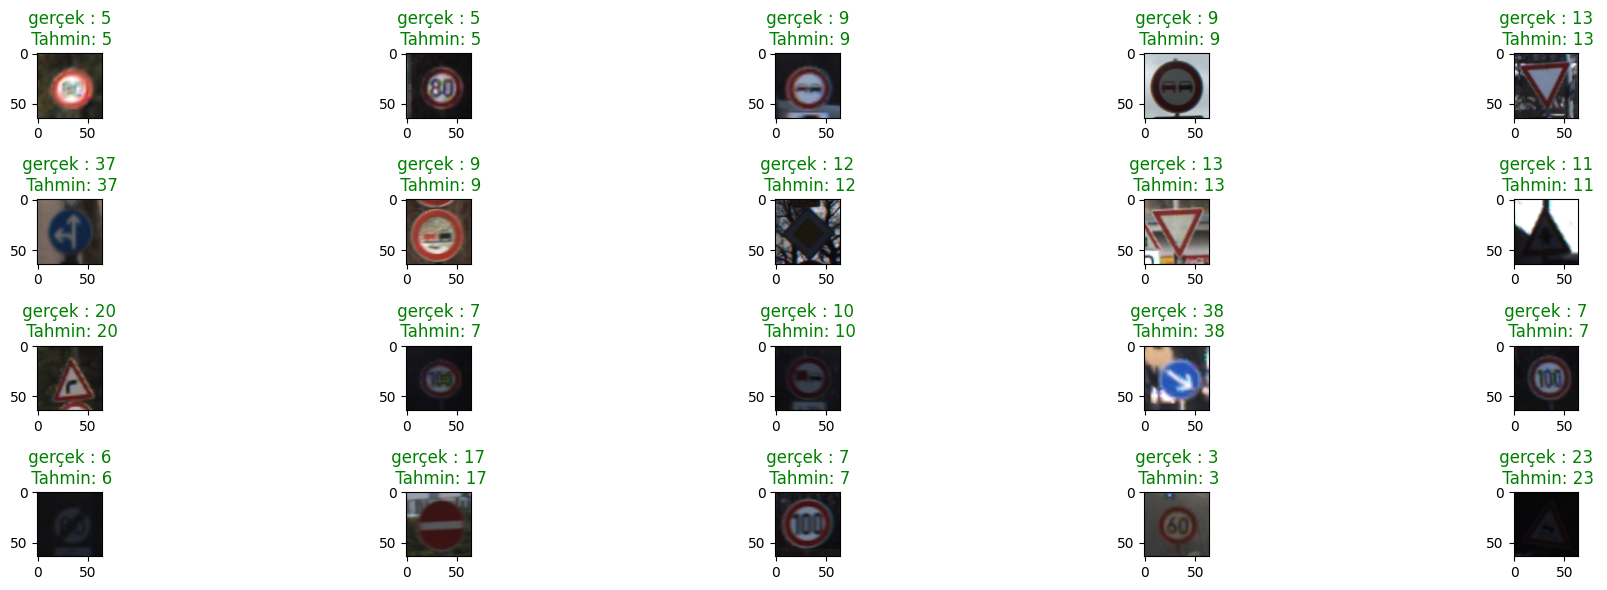

In [31]:
plt.figure(figsize=(20,6))
for i, idx in enumerate(random_indices):
    img=X_test[idx]
    true_label= y_true_classes[idx]
    pred_label= y_pred_classes[idx]

    plt.subplot(4,5,i+1)
    plt.imshow(img)

    color= "green" if true_label == pred_label else "red"
    plt.title(f" gerçek : {true_label} \n Tahmin: {pred_label}", color=color)
plt.tight_layout()
plt.show()

In [116]:
sample_path = "sample7.png"
img = cv2.imread(sample_path)

In [117]:
img = cv2.resize(img, (64,64))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img / 255.0
img = np.expand_dims(img, axis=0)

In [118]:
prediction = first_model.predict(img)
predicted_class = np.argmax(prediction)
confidence_score = prediction[0][predicted_class]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


In [119]:
print(f"Tahmin edilen sınıf: {predicted_class} | Güven skoru: {confidence_score:.2%}")

Tahmin edilen sınıf: 11 | Güven skoru: 99.96%


In [120]:
sample_from_train = train_df[train_df["ClassId"] == predicted_class].sample(1).iloc[0]
train_sample_path = os.path.join("C:/Users/PANDA/traffic/", sample_from_train["Path"])
train_sample_img = Image.open(train_sample_path)

In [121]:
input_img_vis = cv2.imread(sample_path)
input_img_vis = cv2.cvtColor(input_img_vis, cv2.COLOR_BGR2RGB)

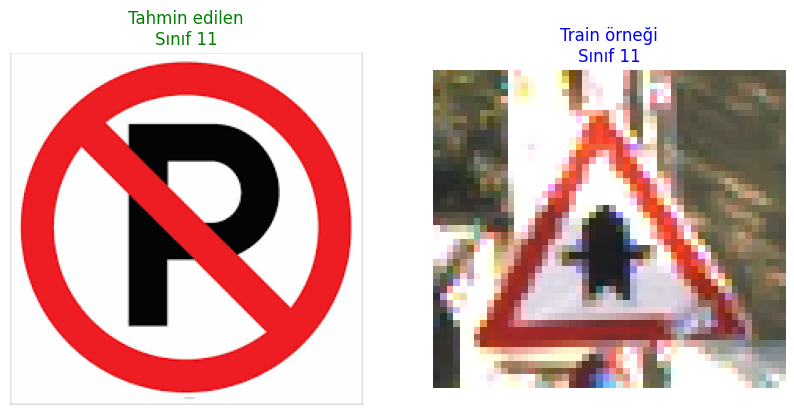

In [122]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_img_vis)
plt.title(f"Tahmin edilen\nSınıf {predicted_class}", color="green")
plt.axis("off")


plt.subplot(1, 2, 2)
plt.imshow(train_sample_img)
plt.title(f"Train örneği\nSınıf {predicted_class}", color="blue")
plt.axis("off")
plt.show()

## Fine tuning
- Modelin performans sonuçları çok iyi fakat gerçek dünya verisinde sorun yaşıyor. O yüzden şimdi daha düzenli olması için modeli tekrar eğitip fine-tuning yapacağım fakat tekrar eğitmeden önce model mimarisini fonksiyon olarak tanımlayacağım daha düzenli olması için

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
first_model.compile(optimizer=Adam(0.00005), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
fine_tune_datagen= ImageDataGenerator(rotation_range=15,
                                      width_shift_range=0.12,
                                      height_shift_range=0.12,
                                      zoom_range=0.25,
                                      shear_range=0.1,
                                      horizontal_flip=False,
                                      fill_mode="nearest",
                                      brightness_range=[0.8, 1.3],
                                      channel_shift_range=0.7)

In [ ]:
fine_tune_train_generator = fine_tune_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)

In [ ]:
#fine tune için yeni callback
fine_tune_callbacks= [ ModelCheckpoint("gtsrb_fine_tuned_best.weights.h5", monitor= "val_accuracy", save_best_only=True, verbose=1),
                       EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True, verbose=1),
                       ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)]             

In [ ]:
fine_tune_history= first_model.fit(fine_tune_train_generator, validation_data=val_generator, epochs=5, callbacks=fine_tune_callbacks)

## Transfer Learning 
- Bu adımda modelin gerçek dünya verilerindeki genelleme yeteneğini arttırmak amacıyla Transfer Learning yapacağız.
- ResNet50 kullanacağız. 
- girdi - 224,224,3 yani 224x224 boyutlu RGB görüntü buna göre veri setini tekrar yükleyeceğiz ve modele uygun hale getireceğiz
- section halinde run edilirse diye karışıklık olmaması için labelları da yükleyip one hot encoding yapacağım.

In [6]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.losses import CategoricalCrossentropy

In [14]:
train_df= pd.read_csv("Train.csv", usecols=["ClassId", "Path"])
test_df=pd.read_csv("Test.csv", usecols=["ClassId", "Path"])
train_df["ClassId"] = train_df["ClassId"].astype(str)
test_df["ClassId"] = test_df["ClassId"].astype(str)

In [125]:
train_df, val_df= train_test_split(train_df, test_size=0.2, random_state=42)

In [126]:
train_datagen= ImageDataGenerator(preprocessing_function=preprocess_input,
                                  rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  zoom_range=0.1,
                                  shear_range=0.05,
                                  horizontal_flip=False)

In [127]:
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [128]:
batch_size=32
target_size=(224,224)

In [129]:
train_generator= train_datagen.flow_from_dataframe(dataframe=train_df,
                                                   directory="C:/Users/PANDA/traffic/",
                                                   x_col="Path",
                                                   y_col="ClassId",
                                                   target_size=target_size,
                                                   batch_size=batch_size,
                                                   class_mode="categorical",
                                                   shuffle=True)

Found 31367 validated image filenames belonging to 43 classes.


In [130]:
val_generator= val_datagen.flow_from_dataframe(dataframe=val_df,
                                                 directory="C:/Users/PANDA/traffic/",
                                                 x_col="Path",
                                                 y_col="ClassId",
                                                 target_size=target_size,
                                                 batch_size=batch_size,
                                                 class_mode="categorical",
                                                 shuffle=False)

Found 7842 validated image filenames belonging to 43 classes.


In [131]:
test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                  directory="C:/Users/PANDA/traffic/",
                                                  x_col="Path",
                                                  y_col="ClassId",
                                                  target_size=target_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False)

Found 12630 validated image filenames belonging to 43 classes.


In [132]:
#batchleri kontrol edelim
x_batch, y_batch= next(train_generator)
print("x batch shape", x_batch.shape)
print("y batch shape", y_batch.shape)
print("sinif dağılım y için", y_batch[0])

x batch shape (32, 224, 224, 3)
y batch shape (32, 43)
sinif dağılım y için [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [133]:
val_counts = val_generator.classes
np.unique(val_counts, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 array([ 44, 474, 349, 242, 454, 441, 167, 127,  65, 231, 238,  49, 452,
         78,  63,  86, 109,  59, 298, 122,  47,  99,  59, 295,  95, 160,
         41, 138,  88, 224,  80,  47, 418,  58, 420,  60,  47,  41, 332,
         82, 276, 283, 304], dtype=int64))

In [134]:
def build_transfer_model(input_shape=(224, 224, 3), num_classes=43):
    #rn50 modelini içeri aktaralım
    base_model = ResNet50(weights="imagenet", include_top= False, input_shape= input_shape)

    for layer in base_model.layers:
        layer.trainable=False

    x=base_model.output
    x= GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x= Dense(256, activation="relu")(x)
    x= Dropout(0.5)(x)
    predictions = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [135]:
model = build_transfer_model(num_classes=43)

In [136]:
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)

In [137]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss=loss_fn, metrics=["accuracy"])

In [138]:
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,131,499 (92.05 MB)

 Trainable params: 539,691 (2.06 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [139]:
callbacks = [ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True, mode='max'),
             EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=3, verbose=1)]

In [140]:
history= model.fit(train_generator, validation_data=val_generator, epochs=30, callbacks=callbacks)

Epoch 1/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 2323s 2s/step - accuracy: 0.3121 - loss: 3.0846 - val_accuracy: 0.7209 - val_loss: 1.5381 - learning_rate: 1.0000e-04
Epoch 2/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 2065s 2s/step - accuracy: 0.6251 - loss: 1.8370 - val_accuracy: 0.8053 - val_loss: 1.3229 - learning_rate: 1.0000e-04
Epoch 3/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 1988s 2s/step - accuracy: 0.7146 - loss: 1.5884 - val_accuracy: 0.8483 - val_loss: 1.2228 - learning_rate: 1.0000e-04
Epoch 4/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 1787s 2s/step - accuracy: 0.7624 - loss: 1.4612 - val_accuracy: 0.8721 - val_loss: 1.1589 - learning_rate: 1.0000e-04
Epoch 5/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 1593s 2s/step - accuracy: 0.7913 - loss: 1.3866 - val_accuracy: 0.8907 - val_loss: 1.1129 - learning_rate: 1.0000e-04
Epoch 6/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 1593s 2s/step - accuracy: 0.8202 - loss: 1.3118 - val_accuracy: 0.9010 - val_loss: 1.0819 - learning_rate: 1.0000e-04
Epoch 7/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 1854s 2s/ste

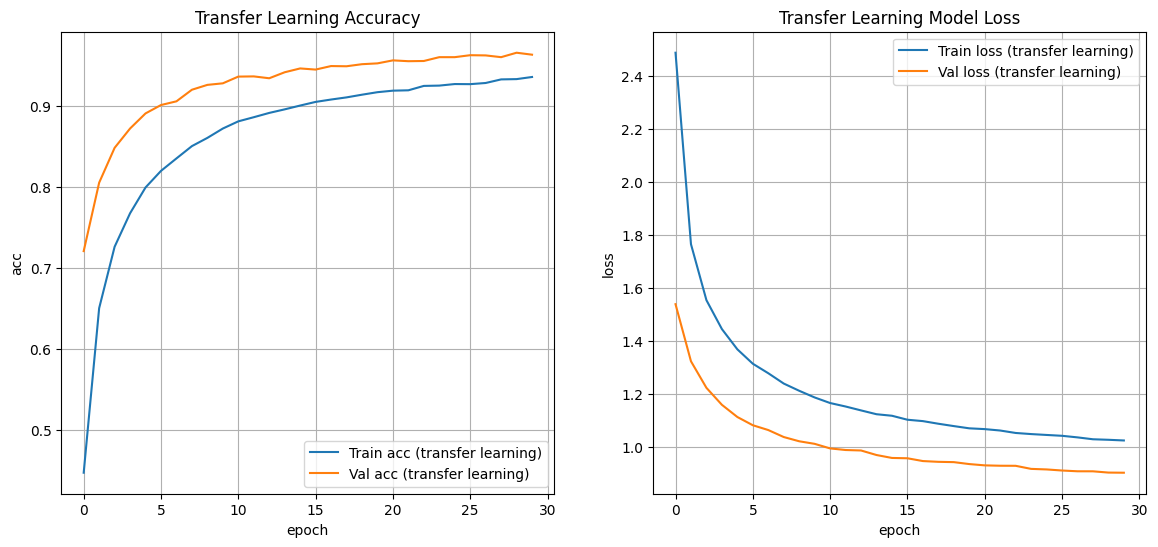

In [141]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train acc (transfer learning)")
plt.plot(history.history["val_accuracy"], label="Val acc (transfer learning)")
plt.title("Transfer Learning Accuracy")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train loss (transfer learning)")
plt.plot(history.history["val_loss"], label="Val loss (transfer learning)")
plt.title("Transfer Learning Model Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

In [145]:
model = load_model("best_model.keras")

In [146]:
for layer in model.layers[-40:]:
    layer.trainable = True

In [147]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss=loss_fn, metrics=["accuracy"])

In [148]:
callbacks_finetune_tl= [ModelCheckpoint("best_model_finetuned.keras", monitor="val_accuracy", save_best_only=True, mode="max"),
                        EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=2, min_lr=1e-6, verbose=1)]

In [149]:
history_ft= model.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=callbacks_finetune_tl)

Epoch 1/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 2554s 3s/step - accuracy: 0.8851 - loss: 1.1489 - val_accuracy: 0.9694 - val_loss: 0.9127 - learning_rate: 1.0000e-05
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 3021s 3s/step - accuracy: 0.9467 - loss: 1.0012 - val_accuracy: 0.9799 - val_loss: 0.8788 - learning_rate: 1.0000e-05
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 2792s 3s/step - accuracy: 0.9612 - loss: 0.9528 - val_accuracy: 0.9847 - val_loss: 0.8560 - learning_rate: 1.0000e-05
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 2726s 3s/step - accuracy: 0.9713 - loss: 0.9215 - val_accuracy: 0.9869 - val_loss: 0.8413 - learning_rate: 1.0000e-05
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 2341s 2s/step - accuracy: 0.9810 - loss: 0.8986 - val_accuracy: 0.9913 - val_loss: 0.8245 - learning_rate: 1.0000e-05
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 2310s 2s/step - accuracy: 0.9829 - loss: 0.8845 - val_accuracy: 0.9921 - val_loss: 0.8160 - learning_rate: 1.0000e-05
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 2316s 2s/ste

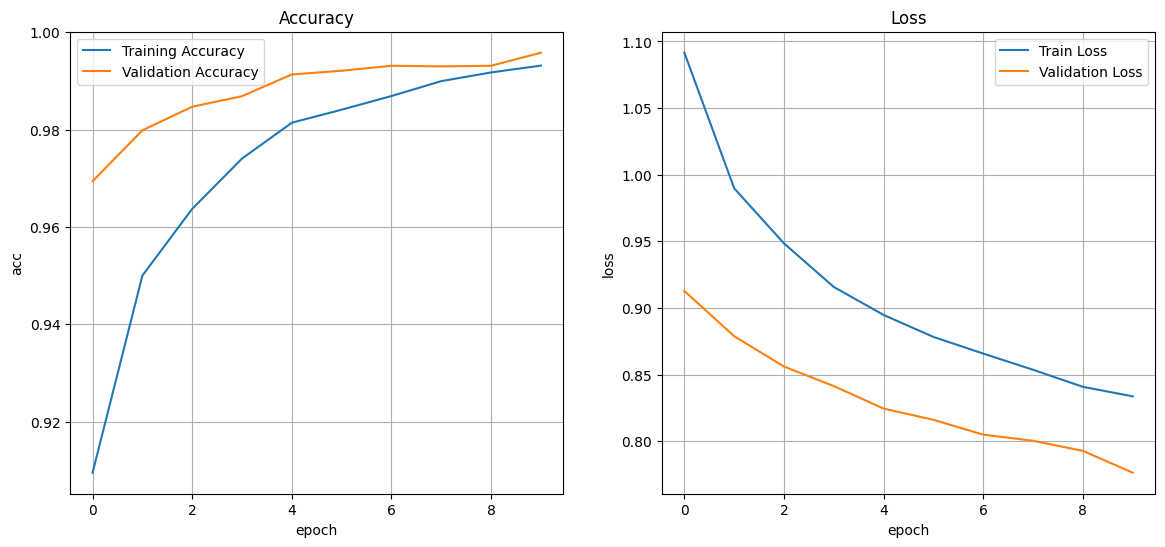

In [150]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(history_ft.history["accuracy"], label="Training Accuracy")
plt.plot(history_ft.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history_ft.history["loss"], label="Train Loss")
plt.plot(history_ft.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

In [151]:
test_loss, test_acc = model.evaluate(test_generator) 
print(f" test accuracy : {test_acc}")

395/395 ━━━━━━━━━━━━━━━━━━━━ 548s 1s/step - accuracy: 0.9200 - loss: 0.9839
 test accuracy : 0.9153602719306946


In [152]:
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 536s 1s/step


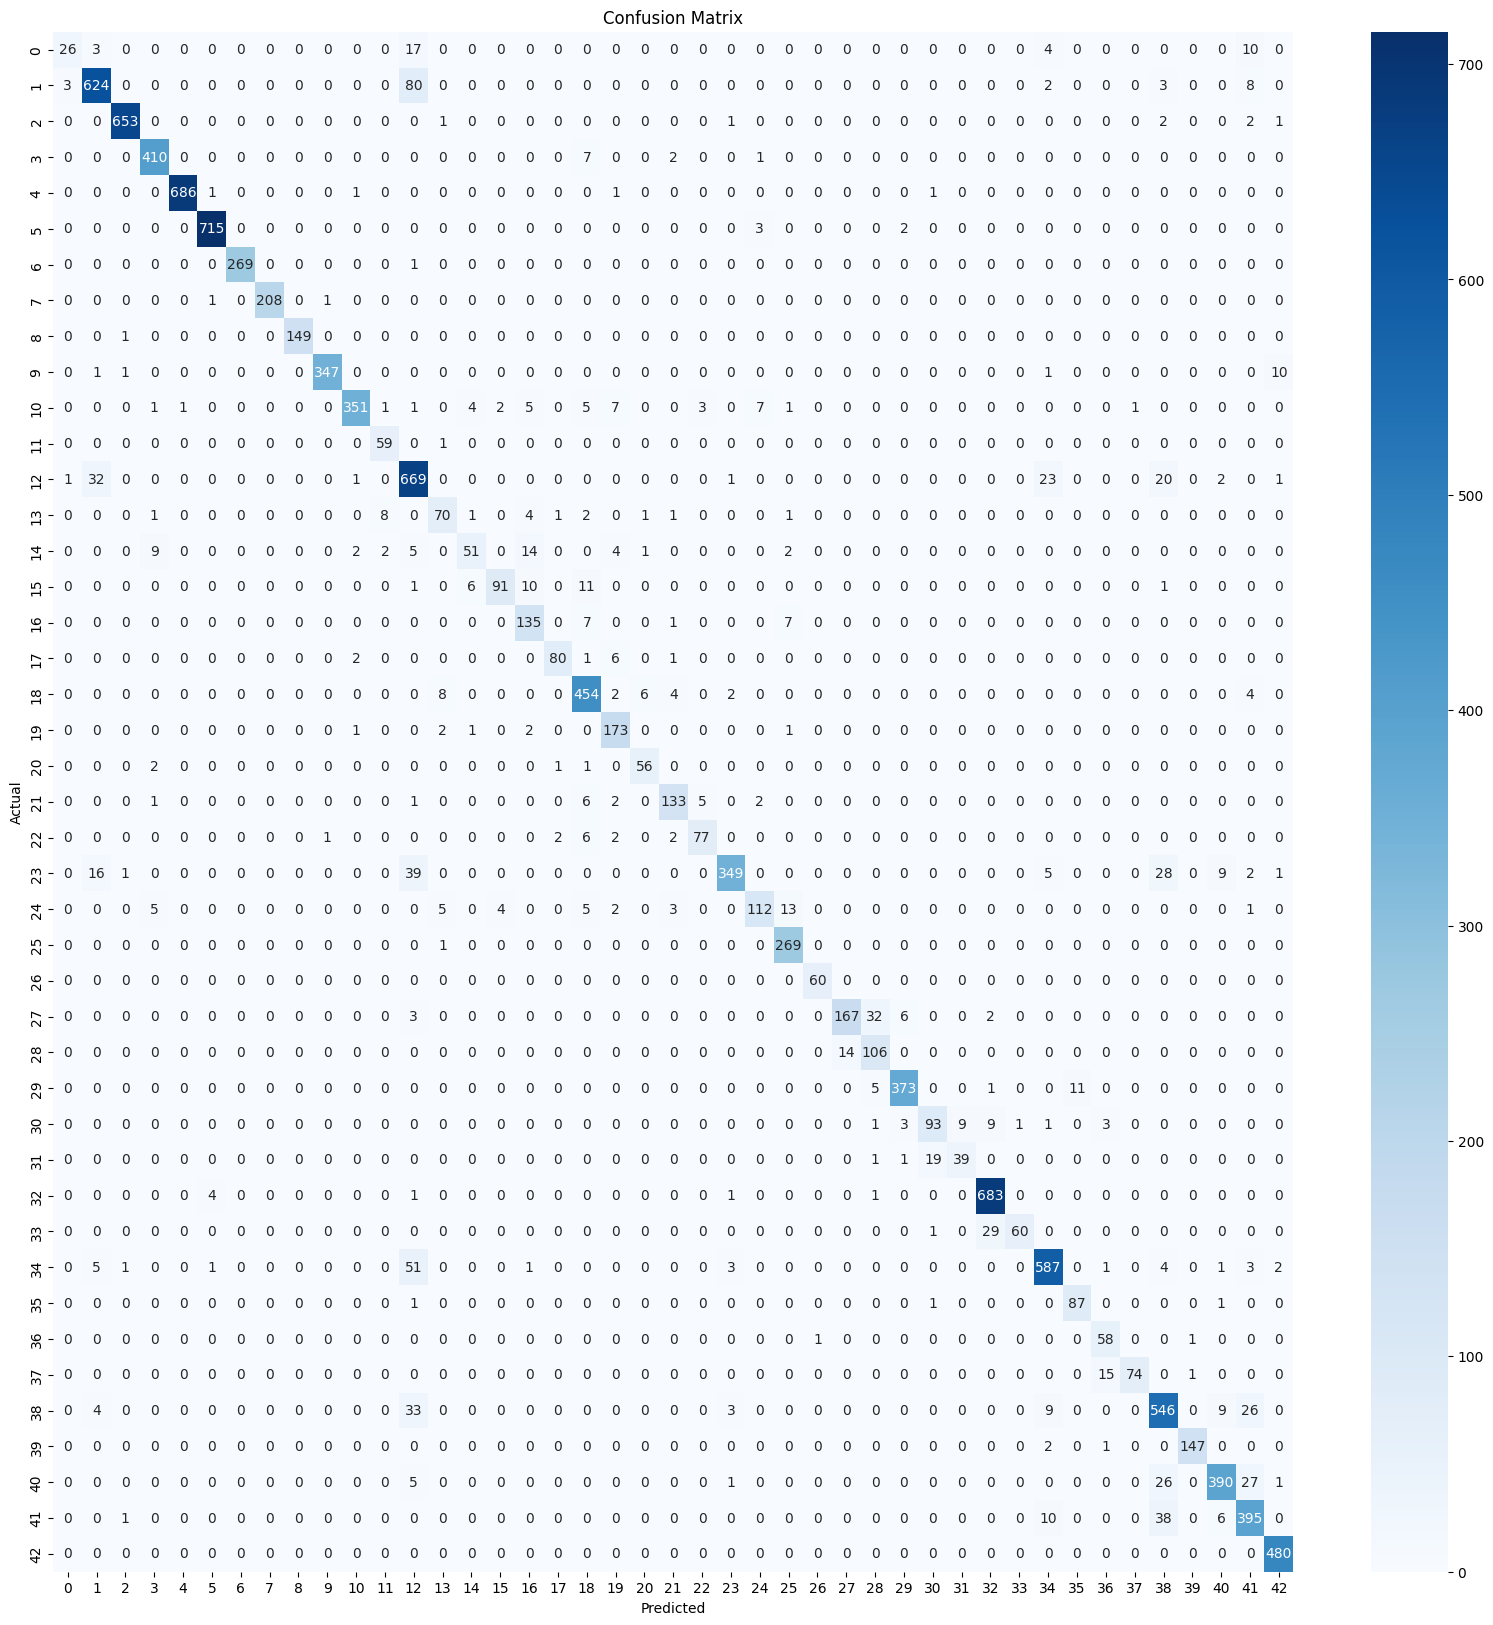

In [153]:
plt.figure(figsize=(20,20))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [9]:
model=load_model("best_model_finetuned.keras")

In [19]:
BASE_DIR = "C:/Users/PANDA/traffic/" 

def predict_and_visualize(img_path, model, train_df, base_dir):
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, (224, 224))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB) 
    img_processed = img_rgb.astype("float32")
    img_processed = preprocess_input(img_processed) 
    img_processed = np.expand_dims(img_processed, axis=0) 

    prediction = model.predict(img_processed)[0] 
    predicted_class_id = np.argmax(prediction) 
    confidence = prediction[predicted_class_id] 
    predicted_class_str = str(predicted_class_id)

    print(f"Tahmin edilen sınıf: {predicted_class_str} | Güven skoru: {confidence:.2f}%") 
    
    sample_from_train_df = train_df[train_df["ClassId"] == predicted_class_str].sample(1).iloc[0]
    train_sample_relative_path = sample_from_train_df["Path"]
    train_sample_full_path = os.path.join(base_dir, train_sample_relative_path) 

    train_sample_img_bgr = cv2.imread(train_sample_full_path)
    train_sample_img_rgb = cv2.cvtColor(train_sample_img_bgr, cv2.COLOR_BGR2RGB) 

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1) 
    plt.imshow(img_rgb) 
    plt.title(f"Tahmin Edilen\nSınıf {predicted_class_str}", color="green") 
    plt.axis("off")
    
    plt.subplot(1, 2, 2) 
    plt.imshow(train_sample_img_rgb) 
    plt.title(f"Train Örneği\nSınıf {predicted_class_str}", color="blue") 
    plt.axis("off") 

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Tahmin edilen sınıf: 34 | Güven skoru: 0.96%


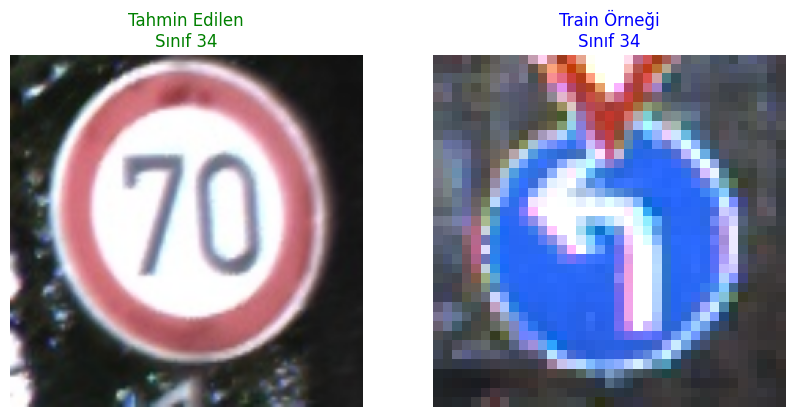

In [35]:
predict_and_visualize("70.png", model, train_df, BASE_DIR)